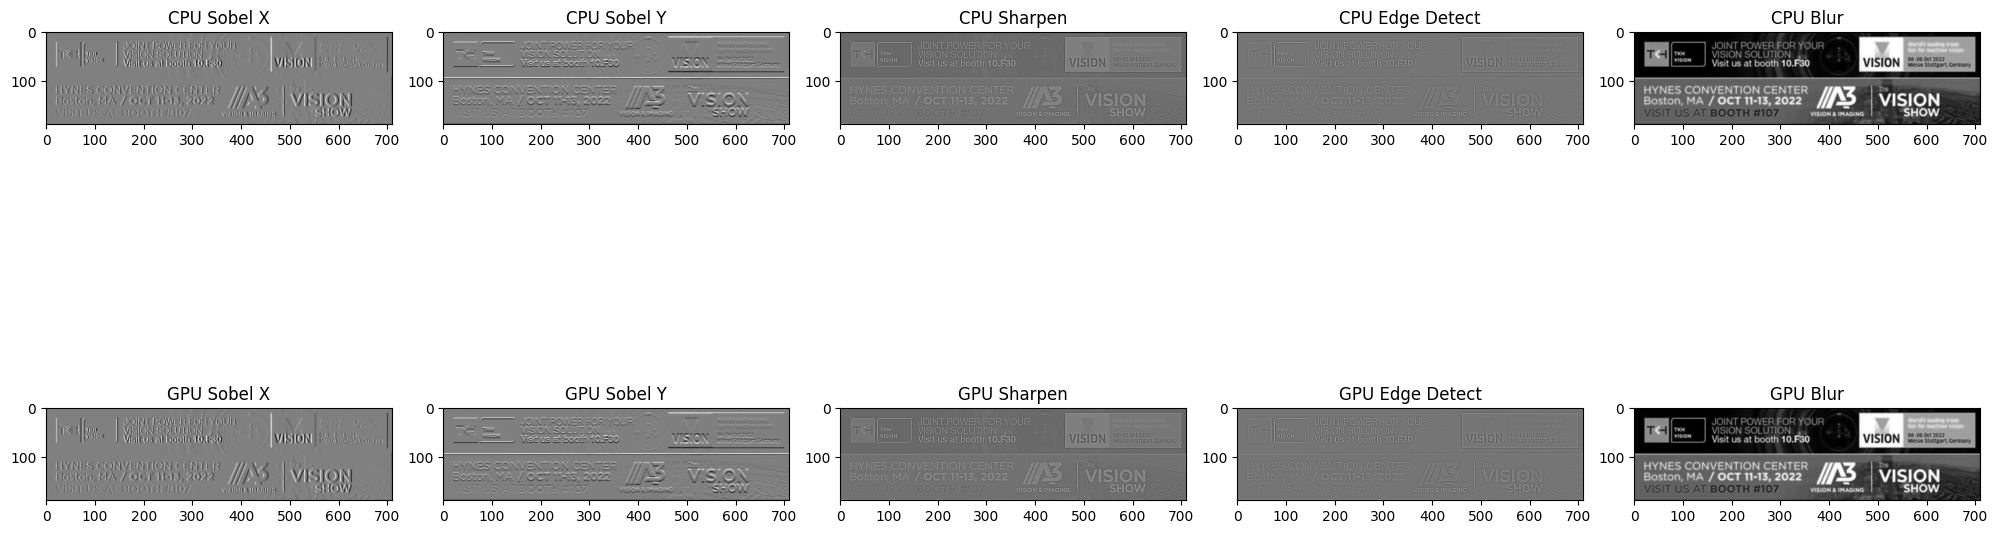

Sobel X Filter - CPU Execution Time: 0.1279149055480957 seconds, GPU Execution Time: 3.874128818511963 seconds
Sobel Y Filter - CPU Execution Time: 0.05117297172546387 seconds, GPU Execution Time: 0.0021331310272216797 seconds
Sharpen Filter - CPU Execution Time: 0.0683743953704834 seconds, GPU Execution Time: 0.0003032684326171875 seconds
Edge Detect Filter - CPU Execution Time: 0.041652679443359375 seconds, GPU Execution Time: 0.00018787384033203125 seconds
Blur Filter - CPU Execution Time: 0.03202462196350098 seconds, GPU Execution Time: 0.00015735626220703125 seconds


In [ ]:
# ****************************************** written by Alireza ***************************************
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import numpy as np

# Load image using TensorFlow
image_path = "img.jpg"

# Load and decode the image
image_string = tf.io.read_file(image_path)
image_decoded = tf.image.decode_jpeg(image_string, channels=3)
image = tf.image.convert_image_dtype(image_decoded, tf.float32)

# Ensure the image has 4 dimensions
image = tf.expand_dims(image, axis=0)

# Prepare kernels for filters
sobel_x = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=tf.float32, shape=(3,3,1,1))
sobel_y = tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=tf.float32, shape=(3,3,1,1))
sharpen = tf.constant([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]], dtype=tf.float32, shape=(3,3,1,1))
edge_detect = tf.constant([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=tf.float32, shape=(3,3,1,1))
blur = tf.constant([[1/16, 1/8, 1/16], [1/8, 1/4, 1/8], [1/16, 1/8, 1/16]], dtype=tf.float32, shape=(3,3,1,1))

# Create a list of kernels for each color channel
kernels = [sobel_x, sobel_y, sharpen, edge_detect, blur]
kernels = [tf.concat([kernel, kernel, kernel], axis=2) for kernel in kernels]  # Copy the kernel to all color channels

# Define function to apply custom filter
def apply_filter(image, kernel):
    return tf.nn.conv2d(input=image, filters=kernel, strides=[1, 1, 1, 1], padding='SAME')


# CPU Image Processing
def cpu_image_processing(image):
    execution_times = []
    filtered_images = []
    with tf.device('/CPU:0'):
        for kernel in kernels:
            start_time = time.time()
            filtered_image = apply_filter(image, kernel)
            end_time = time.time()
            execution_times.append(end_time - start_time)
            filtered_images.append(filtered_image)
    return filtered_images, execution_times

# GPU Image Processing
def gpu_image_processing(image):
    execution_times = []
    filtered_images = []
    with tf.device('/GPU:0'):
        for kernel in kernels:
            start_time = time.time()
            filtered_image = apply_filter(image, kernel)
            end_time = time.time()
            execution_times.append(end_time - start_time)
            filtered_images.append(filtered_image)
    return filtered_images, execution_times

# Run CPU Image Processing
cpu_results, cpu_execution_times = cpu_image_processing(image)

# Run GPU Image Processing
gpu_results, gpu_execution_times = gpu_image_processing(image)

# Display the results and execution times
filters = ['Sobel X', 'Sobel Y', 'Sharpen', 'Edge Detect', 'Blur']
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i, (cpu_result, gpu_result, filter_name) in enumerate(zip(cpu_results, gpu_results, filters)):
    axes[0, i].imshow(cpu_result[0], cmap='gray')
    axes[0, i].set_title(f"CPU {filter_name}")

    axes[1, i].imshow(gpu_result[0], cmap='gray')
    axes[1, i].set_title(f"GPU {filter_name}")

plt.tight_layout()
plt.show()

for i, (cpu_execution_time, gpu_execution_time, filter_name) in enumerate(zip(cpu_execution_times, gpu_execution_times, filters)):
    print(f"{filter_name} Filter - CPU Execution Time: {cpu_execution_time} seconds, GPU Execution Time: {gpu_execution_time} seconds")


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


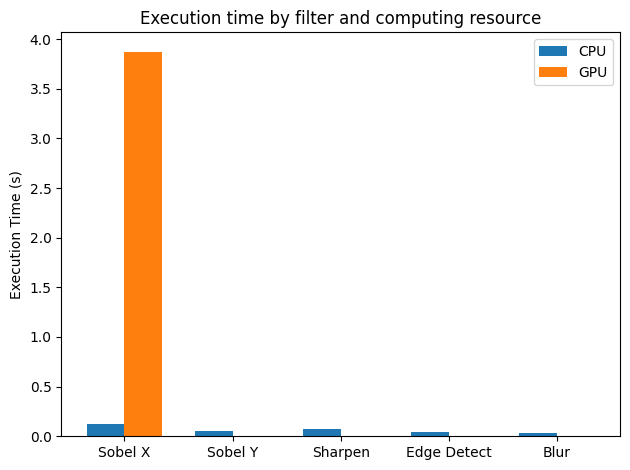

In [ ]:
import numpy as np

# Assuming that you have recorded execution times for CPU and GPU in cpu_execution_times and gpu_execution_times respectively
# for each filter in the same order as they are in the kernels list.

filter_names = ["Sobel X", "Sobel Y", "Sharpen", "Edge Detect", "Blur"]

x = np.arange(len(filter_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cpu_execution_times, width, label='CPU')
rects2 = ax.bar(x + width/2, gpu_execution_times, width, label='GPU')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Execution Time (s)')
ax.set_title('Execution time by filter and computing resource')
ax.set_xticks(x)
ax.set_xticklabels(filter_names)
ax.legend()

fig.tight_layout()

plt.show()
